# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Classification with MLP



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

###  Use only the libraries below:

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

<div class="theme"> Overview </div> 

### Galaxy Zoo
For this homework you will work with real astronomical data with the purpose of classifying galaxies based on visual attributes as they appear in astronomical surveys of the night sky, such as color and morphology. Galaxy morphology is strongly correlated with many physical parameters of those astronomical bodies, including their mass, density distribution, temperature, and star formation history. In turn, these parameters can be estimated using observations of the attributes mentioned above. 

The Galaxy Zoo project includes collected morphological attributes of nearly 900,000 galaxies drawn from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr15/en/home.aspx). The annotation was provided by hundreds of thousands of volunteers, or 'citizen scientists' as we call them, who voted on the galaxy type based only on its image (for more details on galaxy morphology and classification see <a href="https://academic.oup.com/mnras/article/410/1/166/1032478">Chris Lintott et al.</a>). 

Your task is to train a binary classifier on the Galaxy Zoo data in order to distinguish an elliptical galaxy from spirals, mergers and unknown, which we will call non-elliptical galaxies, based on its visual morphology.  

We provide a subset of data in `galaxy_morphology_labeled.csv` so there is no need for you to download it. The full dataset is available at http://data.galaxyzoo.org.


<span class='sub-q'> Dataset Attributes:</span>
- **green_color**: the amount of light measured in the green frequency band (wavelength range 464 $\pm$ 128~nm)
- **red_color**: the amount of light measured in the red frequency band (wavelength range 658 $\pm$ 138~nm)
- **infrared_color**: the amount of light measured in the infrared frequency band (wavelength range 806 $\pm$ 149~nm)
- **de_vaucouleurs_fit_axial_ratio**: axial ratio associated with the [de Vaucouleurs fit](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) to the two-dimensional image of the galaxy
- **exponential_fit_axial_ratio**: the axial ratio associated with an exponential fit to the two-D image of the galaxy 
- **exponential_disc_fit_log_likelihood**: log likelihood associated with an exponential fit to the two-D image of the galaxy
- **de_vaucouleurs_fit_log_likelihood**: log likelihood associated with a de Vaucouleurs fit to the two-D image of the galaxy
- **star_log_likelihood**: the log likelihood that the object is a point-like source (star) object rather than a galaxy
- **number_of_votes**: total number of volunteer votes
- **probability_elliptical**: fraction of votes for elliptical morphology
- **probability_spiral**: fraction of votes for spiral morphology
- **probability_unknown**: fraction of votes for unknown morphology
- **probability_merger**: fraction of votes for merger morphology
- **class**: morphology with the highest fraction of votes

Notice that the volunteers did not have access to any of the attributes but the galaxy shape when voting.

<div class='exercise'><b> Question 1: Models for Galaxy Classification [30pts] </b></div>

<span class='sub-q'> **1.1** Understanding the Problem.</span> It is a good practice to start by familiarizing yourself with the problem in hand. Read the atricle by [Manda Banerji et al.](https://academic.oup.com/mnras/article/406/1/342/1073212) and familiarize yourself with the attributes in the dataset and their descriptions. Based on your reading, which attributes in the data are most predictive of whether or not a galaxy is elliptical?


<span class='sub-q'> 1.2 Performing Data Exploration and Cleaning.</span> 



- **1.2.1** The color bands sometimes include values that are far away from the rest, what we call outliers. Outlier values might indicate bad measurements for example instrumental failures. Remove the data points with these values in the color band of your choice. 
- **1.2.2** Are the features sufficiently distinguishing for the classification task? Do elliptical galaxies differ enough in terms of these attributes from other types of objects in the sky? 

**Hint:** compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set.

<span class='sub-q'> 1.3 Feature Engineering. </span> The practice of creating new features by combining observed features in the data using domain knowledge is called *feature engineering*. Astronomers often use differences in color bands as an engineered feature that serves as a proxy to temperature. Create two new features in the data that represent temperature. Do these two new features help distinguish elliptical galaxies from other objects, i.e., are these two new features useful for the classification task?

<span class='sub-q'> 1.4 Training a Baseline Classifier. </span> Using `keras`, construct and train a MLP classifier to classify galaxies as either elliptical or non-elliptical based on your expanded set of features. 

For the network you want to consider:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function (we suggest starting with `relu`)
- the choice of a loss function
- the choice of mini-batch size (we suggest between 1000 and 5000)
- the choice of an optimizer and its parameters, for example: `learning rate`, `momentum`, and `learning rate decay`
- the number of epochs

**Hint:** You can expect to achieve an average classification accuracy of >80% with the appropriate choices.

<span class='sub-q'>1.5 Evaluating and Improving Your Classifier. </span> Choose an appropriate metric for evaluating your classifier. Is the average classification accuracy a good metric for this data given the distribution of the classes? Improve your classifier based on the distribution of the classes and on your evaluation of the baseline classifier. 

**Hint:** You can expect to achieve an average classification accuracy of >90% with this.

In [5]:
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')
galaxy_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral


<hr> 
### Your solutions 
<hr>

### 1.1 Understanding the problem

### 1.2 Performing Data Exploration and Cleaning

In [8]:
galaxy_df.describe()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger
count,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000
mean,17.070687,16.440295,16.130761,0.608844,0.609354,-3868.090280,-2025.123462,-22239.118941,38.765791,0.365983,0.497452,0.093647,0.042877
std,1.165214,1.249285,1.319114,0.228268,0.221225,9036.116288,5628.712115,30610.822090,13.842021,0.303422,0.341853,0.167825,0.116282
min,7.238786,7.619027,7.231207,0.050000,0.050000,-155600.520000,-165467.890000,-244262.300000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,16.550340,15.859993,15.510974,0.435455,0.437437,-3545.562500,-1676.673825,-25458.852750,28.000000,0.091000,0.143000,0.000000,0.000000
50%,17.319927,16.623186,16.270693,0.634461,0.630144,-730.916850,-676.399390,-11928.960000,34.000000,0.291000,0.561000,0.034000,0.000000
75%,17.833663,17.214431,16.903603,0.796282,0.788374,-133.104103,-284.920380,-5387.488300,51.000000,0.611000,0.812000,0.097000,0.032000
max,20.116318,27.952972,28.606903,0.999995,0.999997,0.000000,0.000000,0.000000,86.000000,1.000000,1.000000,1.000000,0.958000


In [10]:
def scale_num(fit_df, trans_df, non_binary: list):
    # scale
    df_scaled = trans_df.copy()
    scaler = StandardScaler().fit(fit_df[non_binary])
    df_scaled[non_binary] = pd.DataFrame(scaler.transform(df_scaled[non_binary]), index=df_scaled.index, columns=non_binary)
    
    # encode elliptical
    df_dummies = pd.get_dummies(df_scaled, columns=['class'])
    inc_cols = set(df_dummies)^set(['class_merger', 'class_spiral', 'class_unknown'])
    df_scaled = df_dummies[list(inc_cols)]
    
    return(df_scaled)

### 1.2.1

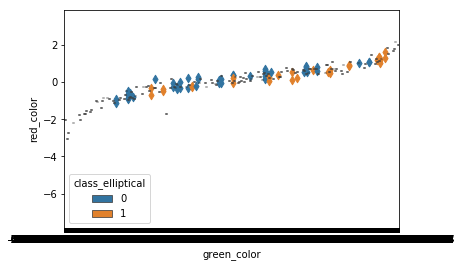

In [51]:
sns.boxenplot(x ='green_color', y='red_color', hue='class_elliptical', data=galaxy_df_scaled)

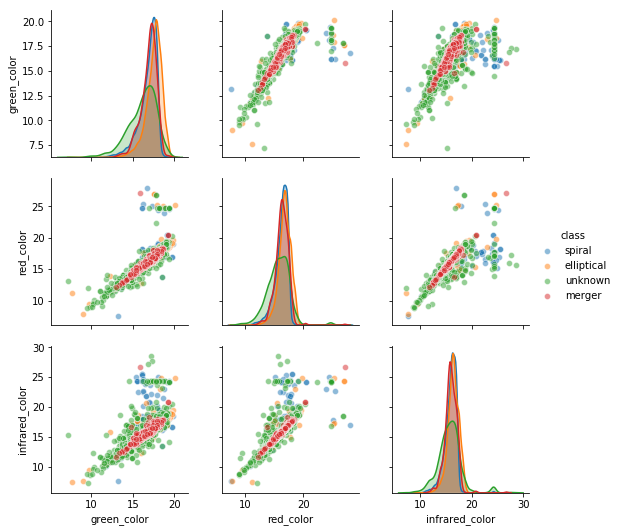

In [17]:
sns.pairplot(galaxy_df[['green_color', 'red_color', 'infrared_color','class']], hue='class', plot_kws={'alpha': 0.5})

In [42]:
galaxy_df = galaxy_df[galaxy_df['red_color']<=21]

### 1.2.2

In [43]:
non_binary = list(set(galaxy_df.columns)^set(['class']))
galaxy_df_scaled = scale_num(fit_df=galaxy_df, trans_df=galaxy_df, non_binary=non_binary)
galaxy_df_scaled.describe()

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,infrared_color,de_vaucouleurs_fit_log_likelihood,probability_spiral,probability_elliptical,exponential_fit_axial_ratio,probability_merger,exponential_disc_fit_log_likelihood,star_log_likelihood,red_color,number_of_votes,probability_unknown,class_elliptical,green_color,de_vaucouleurs_fit_axial_ratio
count,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,2.014100e+04,20141.000000,2.014100e+04,2.014100e+04
mean,-2.569785e-16,-2.317489e-17,6.107224e-15,9.794062e-16,-5.351406e-16,1.922515e-14,-3.164034e-17,5.120608e-17,1.311520e-15,1.130012e-17,2.028902e-14,0.359615,-2.440710e-15,-6.657480e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,0.479899,1.000025e+00,1.000025e+00
min,-6.884648e+00,-2.901919e+01,-1.456208e+00,-1.207040e+00,-2.532233e+00,-3.687452e-01,-1.678167e+01,-7.249701e+00,-7.312054e+00,-2.295207e+00,-5.589636e-01,0.000000,-8.439731e+00,-2.451269e+00
25%,-4.737330e-01,6.202263e-02,-1.037803e+00,-9.071379e-01,-7.773462e-01,-3.687452e-01,3.549739e-02,-1.055609e-01,-4.725222e-01,-7.781214e-01,-5.589636e-01,0.000000,-4.460418e-01,-7.592984e-01
50%,1.149460e-01,2.398477e-01,1.852260e-01,-2.447159e-01,9.360744e-02,-3.687452e-01,3.468122e-01,3.368744e-01,1.607890e-01,-3.446684e-01,-3.548913e-01,0.000000,2.145657e-01,1.119912e-01
75%,6.032913e-01,3.093825e-01,9.196289e-01,8.065908e-01,8.089713e-01,-9.357396e-02,4.136494e-01,5.505396e-01,6.505320e-01,8.834484e-01,2.324265e-02,1.000000,6.554449e-01,8.219005e-01
max,9.669089e+00,3.600608e-01,1.469700e+00,2.088592e+00,1.766427e+00,7.869193e+00,4.284374e-01,7.273032e-01,3.322996e+00,3.411924e+00,5.443162e+00,1.000000,2.397500e+00,1.713811e+00


In [40]:
prob_cols = ['number_of_votes', 'probability_elliptical', 'probability_spiral',
             'probability_unknown', 'probability_merger',]
features = list(set(galaxy_df_scaled.columns)^set(prob_cols))

/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/share/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/share/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/share/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


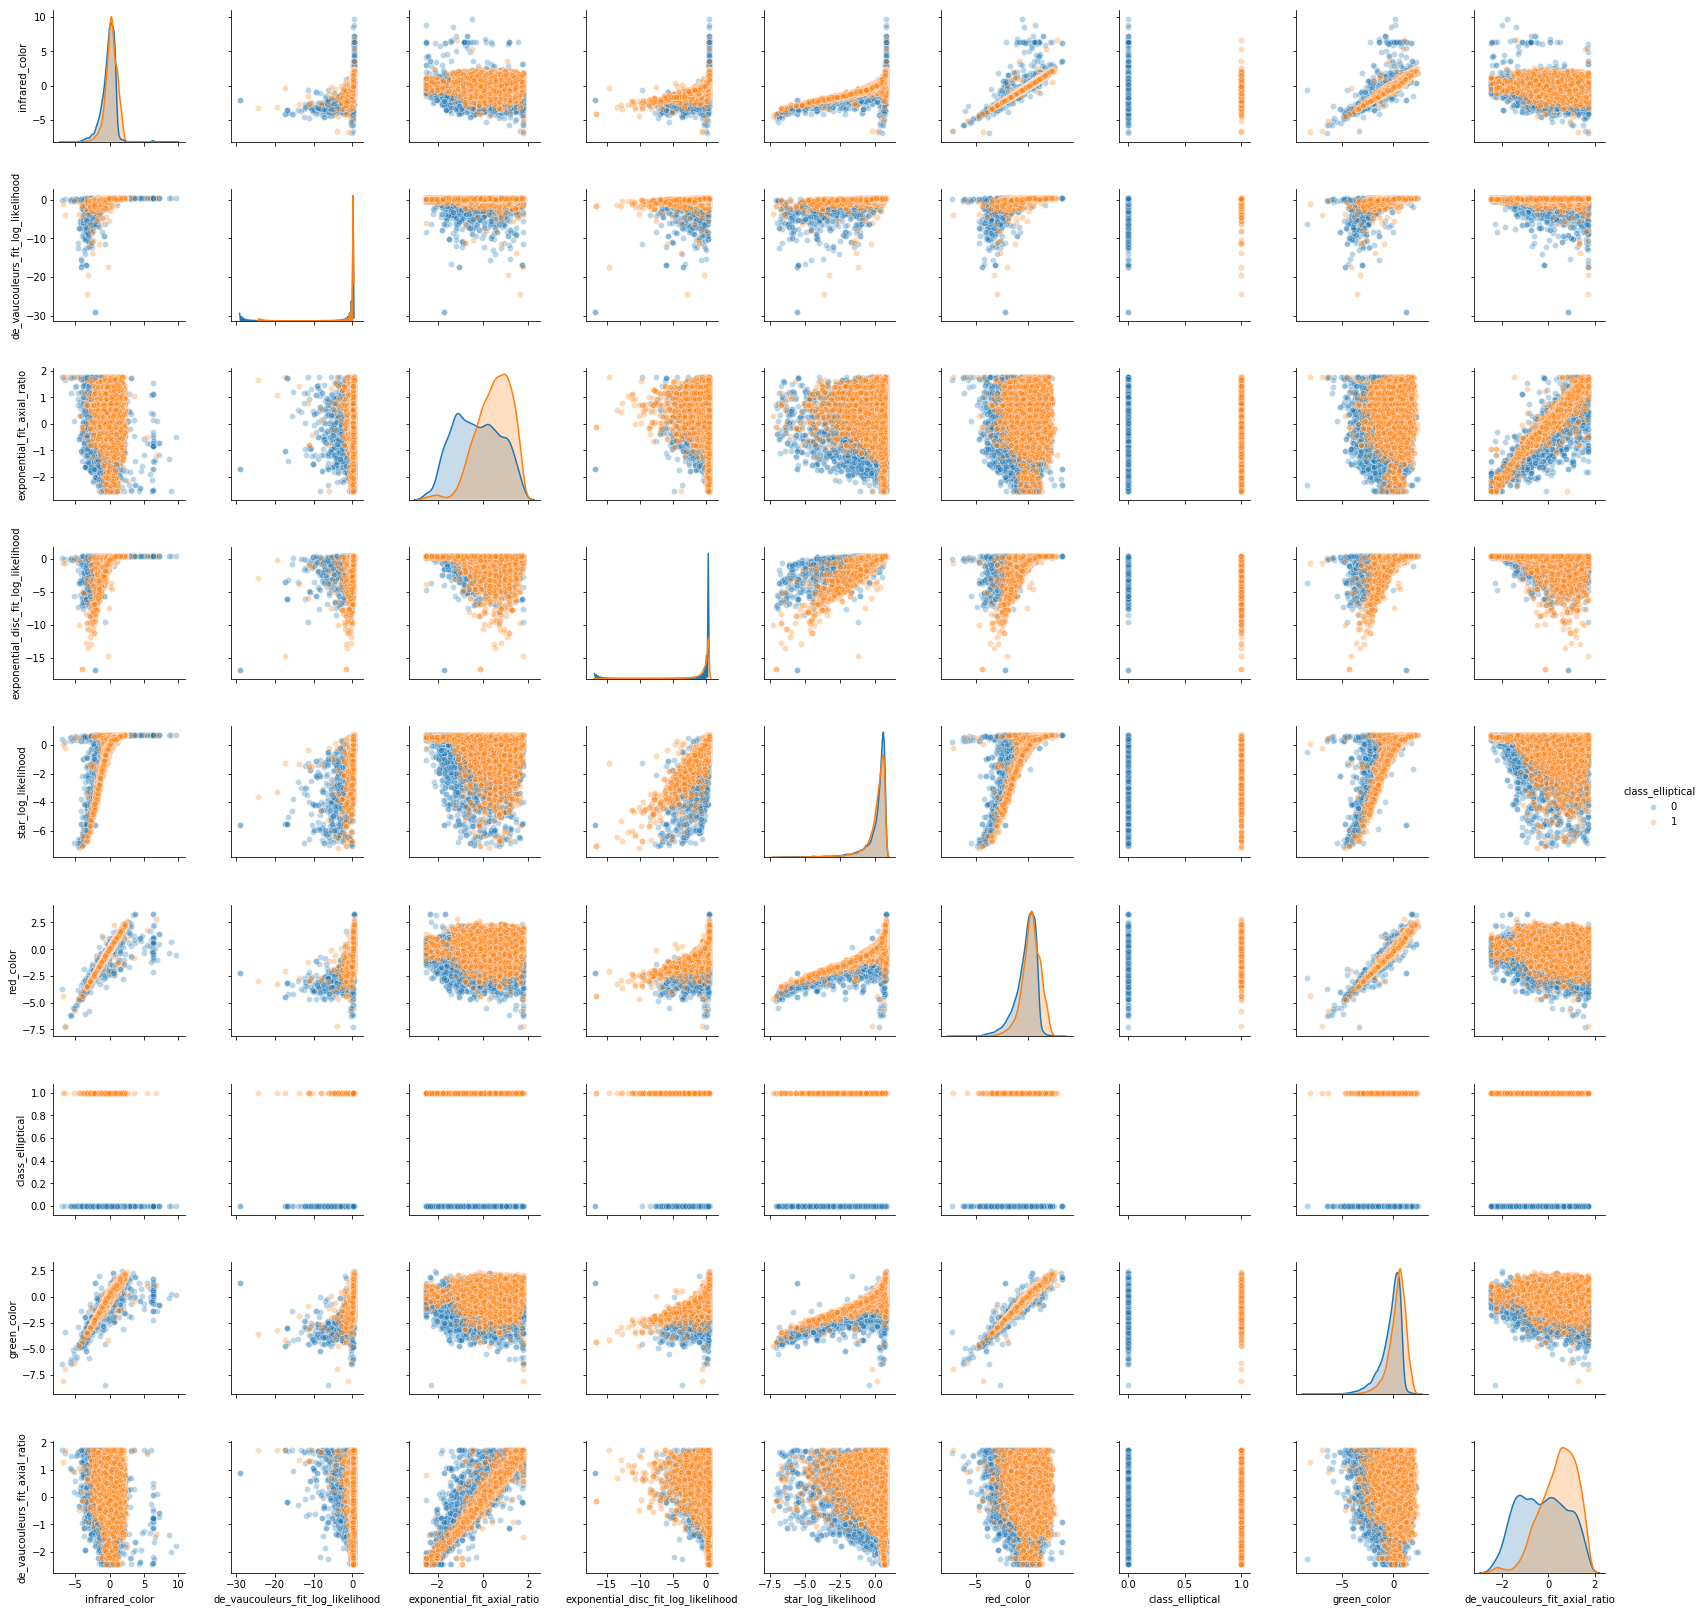

In [44]:
sns.pairplot(galaxy_df_scaled[features], hue='class_elliptical', 
             plot_kws={'alpha': 0.3})

### 1.3 Feature Engineering

In [46]:
galaxy_df_scaled['g-r'] = galaxy_df_scaled['green_color']-galaxy_df_scaled['red_color']
galaxy_df_scaled['r-i'] = galaxy_df_scaled['red_color']-galaxy_df_scaled['infrared_color']

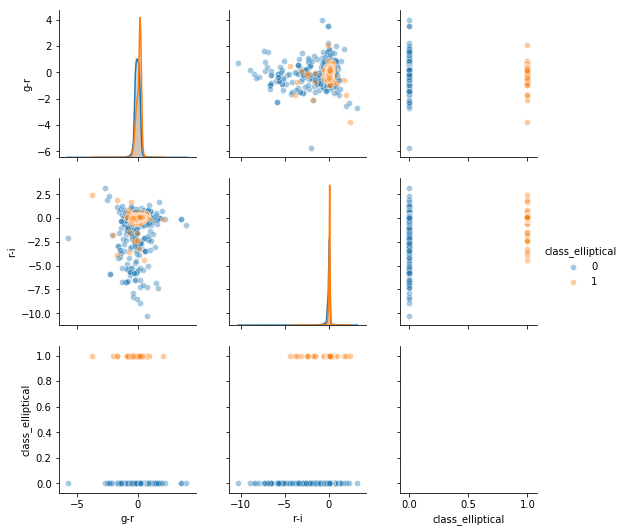

In [49]:
sns.pairplot(galaxy_df_scaled[['g-r','r-i','class_elliptical']], hue='class_elliptical', plot_kws={'alpha': 0.4})

### 1.4 Training a Baseline Classifier

### 1.5 Evaluating and Improving Your Classifier

<div class='exercise'><b> Question 2: Optimization Problems in Model Training </b></div>

In Question 1, you found an appropriate choice of training parameters for your model (e.g. optimizer, learning rate etc). In this problem, you will carefully investigate the effect of these parameters on the baseline model from Question 1.

<span class='sub-q'> 2.1 </span> Using the Adam optimizer, plot the loss function as well as the average classification accuracy [PP: training accuracies] for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set.

<span class='sub-q'> 2.2 </span> Using the SGD optimizer, plot the loss function as well as the average classification accuracy for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set. For the optimal learning rate, experiment with a range of values for momentum, `[9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]` with a learning rate decay of `optimal_rate / total_epochs`. Make an argument for which value of momentum is more appropriate for our data set.

<span class='sub-q'> 2.3 </span> Compare model training using Adam versus SGD:
- describe the difference between the behaviors of these two optimizers. 
- which optimizer gives the best model at the end of say 5000 epochs?

Which optimization method do you prefer for this data set? Why? 
Think of some scenarios where each optimizer might be more appropriate than the other.

Other parameters for optimization include more complex decay rates, you can [read more](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2) about how these choices affect training.

<hr> 
### Your solutions 
<hr>

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 

<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 

<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)

<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

In [6]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


<hr> 
### Your solutions 
<hr>